# SLT-CE-6: Mean Field Approximation

legi 16-952-137

<p style="background-color:#adebad;">
In this coding exercise we will implement a Meand Field Approximation approach and evaluate its performance on two settings we already seen in prior coding exercises:  
    <br> 1) The 2D Ising model (aka image reconstruction model) already seen in Coding Exercise 1 and  </li>
<br> 2) The Wine Dataset already seen in Coding Exercise 2. 
</p>

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt20_lecture08.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise9.pdf)

[3] [Tutorial notes](https://ml2.inf.ethz.ch/courses/slt/tutorials/Tutorial-mean-field-apx.pdf)

[4] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[5] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[6] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

<p style="background-color:#adebad;">In the first part of the coding exercise (Sections 4.0-5.0) we will use the mean field
approximation to solve the 2D Ising model (aka image riconstruction model). 
We have already encountered this 2D Ising model in Coding Exercise 1 (see also the tutorial [3] and exercise [2] -  the model originates from Section 8.3.3 of [5]). 
<br><br>
Your task is to apply/implement the mean field approximation and then compare it to the MCMC (for which we provide you an implementation below).
</p>

## Setup

We start by importing necessary python packages.

In [130]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.ndimage import convolve
from scipy.spatial import distance_matrix
from scipy.special import logsumexp
from scipy.linalg import norm
from scipy.spatial import distance
from sklearn import metrics
from sklearn.cluster import KMeans
from numpy.matlib import repmat
# Embeddings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding


We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [150]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [133]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

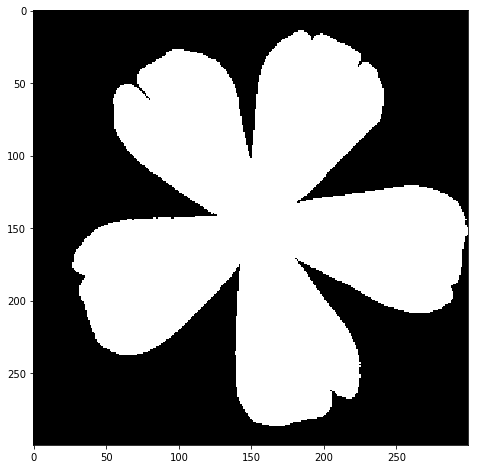

In [134]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [135]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.3 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

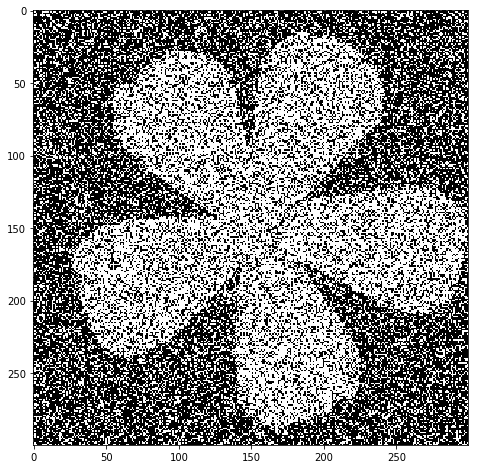

In [136]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as


In [137]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [33]:
def energy(img_estimate, img_noisy_observation):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

In [34]:
energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION)

-300855.94

Estimating loss via mean squared error

In [35]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [49]:
def pixel_energy(img_estimate, img_noisy_observation, i, j, H=H, Beta=Beta, Eta=Eta):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [37]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

1.2
-773448.0
-300855.94


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Briefly recap the theory of the mean field approximation. 
    <br> (You can choose to describe only one of the many derivation given in the tutorial [3], e.g., variational upper bound.)  
</p>


Denote $R(c)$ as a cost function for the assignment $c=(c_1, \ldots, c_n), c_i\in\{1, \ldots, K\}$ to $K$ clusters of all $n$ data instances (all possible assignment form set $\mathcal{C}$, their probabilities are $p(c)$). The correspondent to $R(c)$ Gibbs free energy with temperature $\frac{1}{\beta}$ is denoted as $$G(p) \mathrel{\mathop:}= \underbrace{\sum_{c\in\mathcal{C}} p(c)R(c)}_{\mathbb{E}_p R(c)} + \underbrace{\frac{1}{\beta}\sum_{c\in\mathcal{C}} p(c)\log p(c)}_{-\frac{1}{\beta}H(p)},$$
where $H(p)$ is entropy.

Partition function is $Z(\beta)=\sum_{c\in\mathcal{C}} e^{-\beta R(c)}$.
Denoting free energy $F(\beta) = -\frac{1}{\beta} \log Z(\beta)$ and having for Gibbs distribution $p_\beta$ (from exercise 4) 
$$G(p)=KL(p||p_\beta)+F(\beta).$$ As KL-divergence is non-negative, $F(\beta)$ is a lower bound on this cost.

It's often computationally expensive to calculate partition function. Partition function of distribution $p$ (exponentially many ($O(K^n)$) summands with respect to number of data instances), so we approximate Gibbs distribution $p$ as a multiplication $\hat{p}=\prod_{i=1}^n p_i(c_i)$ of tractable ones for each element. It assumes that assignments of clusters are independent of each other. Set of these distribution we denote as $\mathcal{P}$. 

Therefore entropy also factorizes $H(\hat{p})=\sum_{i=1}^n H(p_i)$.

So we are trying to find $\arg \min_{\hat{p}\in\mathcal{P}} G(\hat{p})$ instead of intractable $\arg \min_{\text{all } p} G(p)$.

<p style="background-color:#adebad;">
With the help of [2,3], explain the algorithm for solving image denoising using mean field approximation.
    <br>
    (Please try to be consistent in notation/symbols used here and in the previous question - same quantities should be denoted with the same symbol.)
</p>

If we have good cost function, for example for spin-like systems (clusters $\pm 1$) with symmetric matrix $J$ which main diagonal is zeros,
$$R(c)=-\frac{1}{2}\sum_{i,j=1}^n J_{ij}c_i c_j - \sum_{k=1}^n h_k c_k.$$
From the Tutorial 9, in this case
$$\mathbb{E}_\hat{p} R(c)=-\frac{1}{2}\sum_{i,j=1}^n J_{ij}\bar{c_i} \bar{c_j} - \sum_{k=1}^n h_k \bar{c_k}, \qquad \bar{c_l}=\mathbb{E}_\hat{p} c_l.$$

This jointly with entropy expansion yields
$$\beta G(\hat{p}) = \beta\left(-\frac{1}{2}\sum_{i,j=1}^n J_{ij}\bar{c_i} \bar{c_j} - \sum_{k=1}^n h_k \bar{c_k}\right) - \sum_{i=1}^n H(p_i).$$

For spin system $H(p_i)=-p_i^+\log p_i^+ - (1-p_i^+)\log (1-p_i^+)$, where $p_i^+ = \frac{e^{a_i}}{e^{a_i} + e^{-a_i}}$, $a_i$ - auxiliary variational parameters.

Minimazing obtained $G(\hat{p})$ w.r.t. $a_i, i=\{1,\ldots, n\}$by inserting this $H(p_i)$, we will have as in Tutorial 9
$$a_i = \beta\left(\sum_{j=1}^n J_{ij} \bar{c_i} + h_i\right)$$
and
$$\bar{c_i} = \tanh(a_i).$$
This pair of equations could be updated alternating them in EM-fashion until convergence.

As in this excercise we have aditional term in overall cost function, namely $-\eta\sum_{i=1}^n c_i c_i^0$, where $c_i^0$ is the initial noisy value, and is therefore constant, so $h_i$ from the previous solution from Tutorial 9 could be just mapped to $h_i+\eta c_i^0$, therefore the EM-update would be (following notation of H - $H$, Beta- $B$ and Eta - $\eta$):
$$a_i=\beta\left(\sum_{j=1}^n J_{ij} \bar{c_i} + H + \eta c_i^0\right)$$
$$\bar{c_i} = \tanh(a_i)$$
where $J_{ij}=B$ for pixels $i$ and $j$ such that they are in 8-neighbourhood of each other (therefore not equal).
$a_i/\beta$ coincides with function $\texttt{pixel_energy}$ defined before if we subtract self-cost $B\bar{c}_i$ (which isn't important for MCMC, but needed for meanfield) and divide by estimated value $\bar{c_i}$.

<p style="background-color:#adebad;">
Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the 'epochs' parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.
    Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Explain clearly the differences between them.
    <br>1) Does your implementation converge faster? 
    <br>2) What are the disadvantages and advantages?
<br><br>
Consider running the comparison on another image to prove your point.
Also, feel free to replace our implementation of MCMC with your own.
</p>

In [122]:
def metropolis(img_noisy_observation, img_original, epochs, T=1.0, mode='line', t_max=1000):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    #T = 1.0

    energy_vals = []
    loss = []
    start_time = time.time()
    for e in range(epochs):
        for step in range(img_original.shape[0] * img_original.shape[1]):
            # how to choose pixels? Randomly or line-by-line
            if mode == 'rand':
                i = np.random.randint(1,  img_original.shape[0] + 1)
                j = np.random.randint(1,  img_original.shape[1] + 1)
            elif mode == 'line':
                i = step // img_original.shape[1] + 1
                j = step %  img_original.shape[1] + 1
            else:
                print("Bad mode")
                return 1
            # calculate local energy
            pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
            # flip the pixel
            img_estimate_padded[i,j] = -img_estimate_padded[i,j]
            # calculate new local energy
            pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
            # energy difference
            dE = pixel_new_energy - pixel_cur_energy
            # do metropolis thingy
            if dE > 0:
                p = 0.5*(1-np.tanh(0.5 / T * dE))
                rr = np.random.rand(1)
                if rr > p:
                    # revert back pixel
                    img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # append energy
            if j % 200 == 0:
                energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))
            execution_time = time.time() - start_time
            if execution_time > t_max:
                return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [198]:
def meanfield(img_noisy_observation, img_original, epochs, T=1.0, 
              mode='line', t_max=1000,
              H=H, Beta=Beta, Eta=Eta):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations
            T (float) - temperature 1/beta
            mode (string) - how to update pixels - randomly ('rand') 
                                                    or line-by-line ('line')

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    
    # Your code should replace the following code, which is given as a placeholder
    # and demonstrates how the returned values are used in the rest of the code
    
    img_estimate = img_noisy_observation.copy()  # will contain \bar{c}_i
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, 
                                          mode='constant', constant_values=0)

    energies = []
    losses = []
    start_time = time.time()
    for i in range(epochs):
        for step in range(img_original.shape[0] * img_original.shape[1]):
            # how to choose pixels? Randomly or line-by-line
            if mode == 'rand':
                i = np.random.randint(1,  img_original.shape[0] + 1)
                j = np.random.randint(1,  img_original.shape[1] + 1)
            elif mode == 'line':
                i = step // img_original.shape[1] + 1
                j = step %  img_original.shape[1] + 1
            else:
                print("Bad mode")
                return 1
            a = 1/T*((H+Beta)*(np.sum(img_estimate_padded[i-1:i+2,j-1:j+2]) \
                                      - img_estimate_padded[i,j]) \
                     + Eta*img_noisy_observation_padded[i,j])
            img_estimate_padded[i, j] = np.tanh(a)
            execution_time = time.time() - start_time
            if execution_time > t_max:
                return img_estimate_padded[1:-1, 1:-1], np.asarray(energies), np.asarray(losses)
        energies.append(energy(img_estimate_padded[1:-1, 1:-1],
                               img_noisy_observation))
        losses.append(mse_loss(img_estimate_padded[1:-1, 1:-1],
                               img_original))
    return img_estimate_padded[1:-1, 1:-1], np.asarray(energies), np.asarray(losses)

In [199]:
def evaluate(method, img_noisy_observation, img_original, 
             epochs=10, mode='rand', t_max=1000, T=1.0,
             H=H, Beta=Beta, Eta=Eta):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original,
                                            epochs=epochs, mode=mode, t_max=t_max,
                                             T=T, H=H, Beta=Beta, Eta=Eta)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. " + str(int(execution_time)) + " seconds, " \
                 + "Energy " + str("{:.0f}".format(energies[-1])) + ", " \
                 + "MSE loss " + str("{:.3f}".format(losses[-1])))
                 
    # show plots
    plt.show()
    return img_estimate, energies, losses

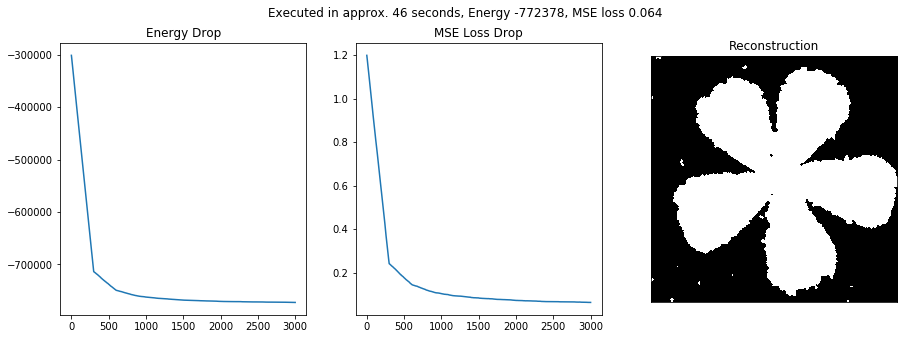

In [95]:
epochs = 10
(img_mcmc, e_mcmc, loss_mcmc) = evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, epochs)

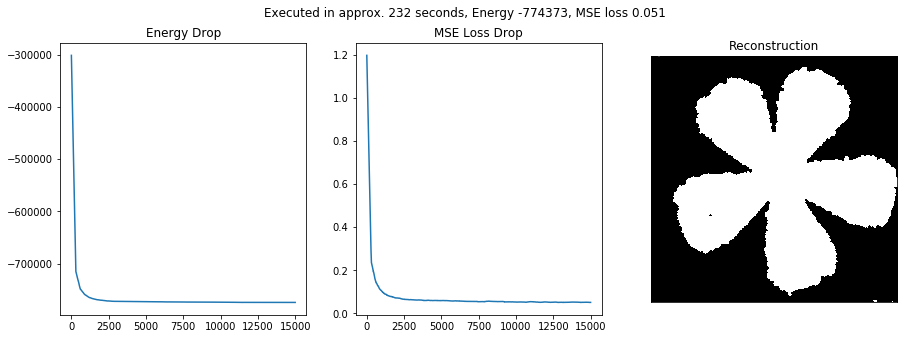

In [103]:
# More epochs for MCMC, 50
(img_mcmc, e_mcmc, loss_mcmc) = evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                         epochs=5*epochs)

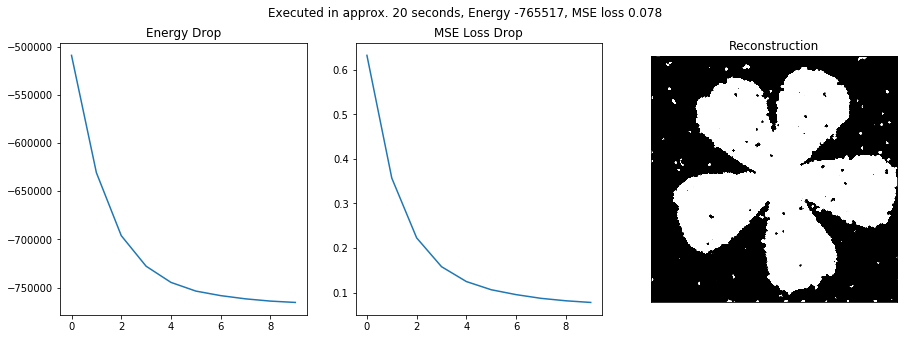

In [96]:
# Evaluate your imlementation of the meanfield
# 10 epochs
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs)

<p style="background-color:#adebad;">
Compare and analyze performance
</p>

1) Does your implementation converge faster?

2) What are the disadvantages and advantages?

Seems that 10 epochs isn't enough for convergence of mean-field (as opposite to MCMC)

So after 10 epochs MSE loss of result is a little more for mean-field

What if we try more epochs?

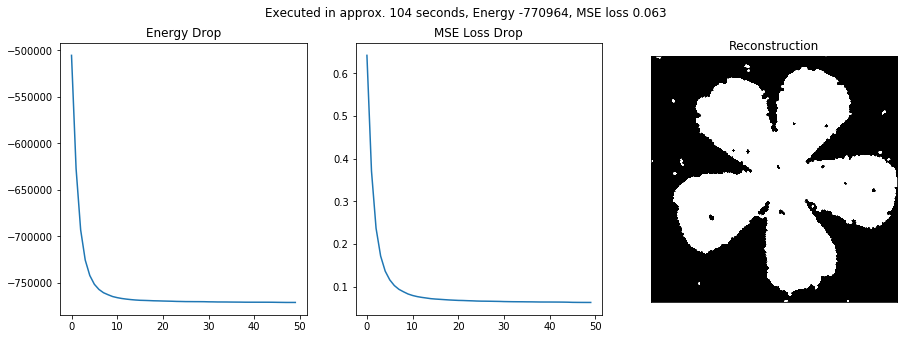

In [105]:
# More epochs, 50
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5*epochs)

Still it's worse than MCMC for 50 epochs

But we used random choice of pixels, maybe it's not so good at practice, though we have theoretical guaranties for random choice (and moreover for MCMC line-by-line choice is used, so why we don't use it?..)

Let's try MCMC with random choice to check that it's really not the best choice empirically (which makes sense, because some pixels are chosen rare and it worsens the quality, though maybe if we launch it for a __really__ long time, it will be good)

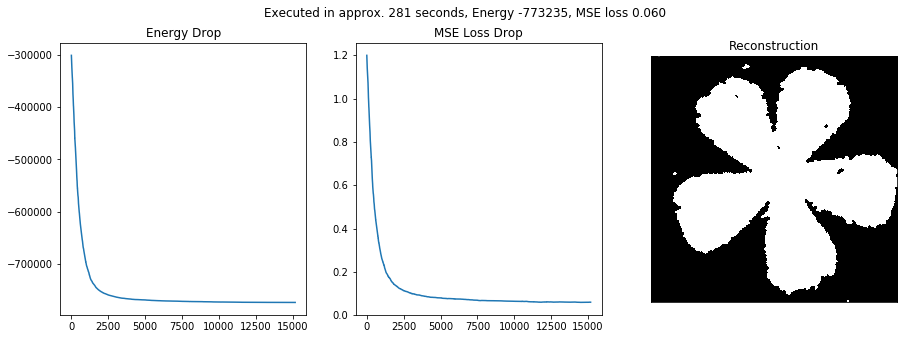

In [110]:
# More epochs for MCMC, random choice
(img_mcmc, e_mcmc, loss_mcmc) = evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                         epochs=5*epochs, mode='rand')

Yes, as we supposed, random choice is worse (MSE 0.06) than line (MSE 0.051) for MCMC too

**Line choice**

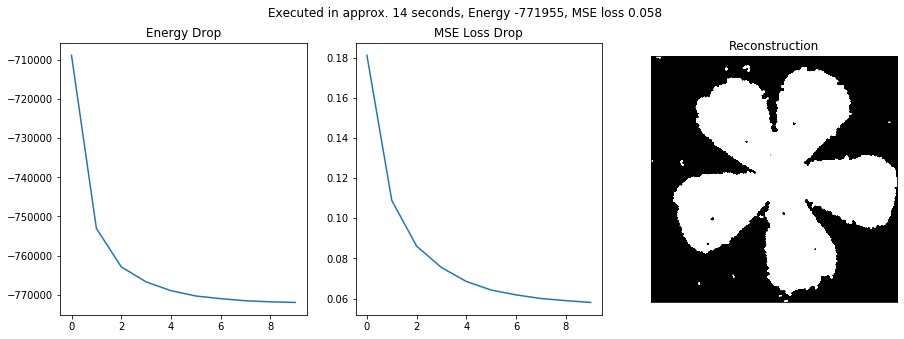

In [107]:
# MF, line-by-line, 10 epochs
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs, mode='line')

Now we have MSE loss 0.058 after 10 epochs, for MCMC it was 0.064, so mean-field with this schedule is much better than MCMC for 10 epochs

What if more epochs?

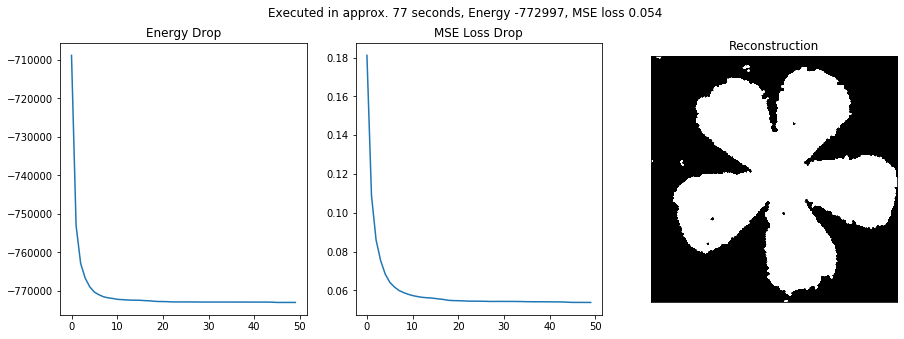

In [108]:
# line-by-line, 50 epochs
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 5*epochs, mode='line')

Here we have MSE loss 0.54, but MCMC with 50 epochs was 0.051, so MF is worse here.

But we compared only using the same __number of epochs__

What if we compare using the same __time of execution__? (which seems to be more reasonable)

Let' run the best found configurations (though we haven't changed H, Beta and Eta yet - later we'll do it), which is line choice

For a fixed time - 1 minute (suppose it's our level of patience; we can of course plot then curve varying times, if we want)

MCMC

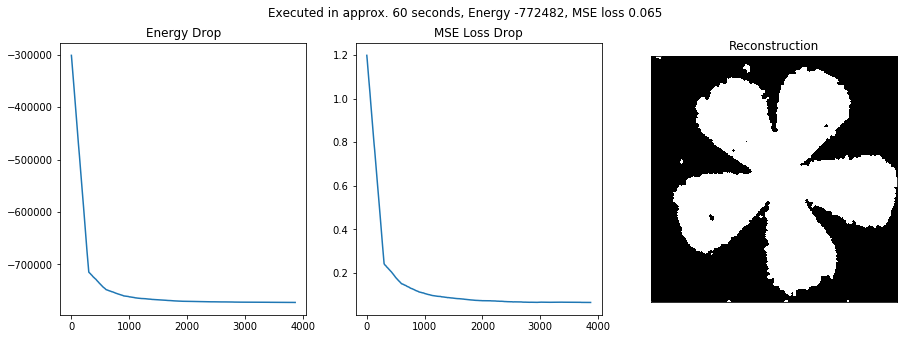

In [123]:
# line-by-line, 1 minute
img_mcmc, e_mcmc, loss_mcmc = evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                         epochs=5*epochs, mode='line', t_max=60)

MF

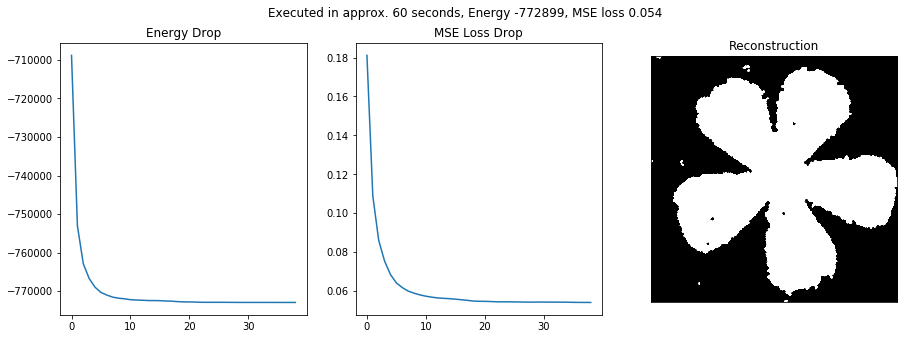

In [124]:
# line-by-line, 1 minute
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60)

Here we see, that mean-field is actually better (0.054 vs 0.065)

If time is 10 second MF is better too:

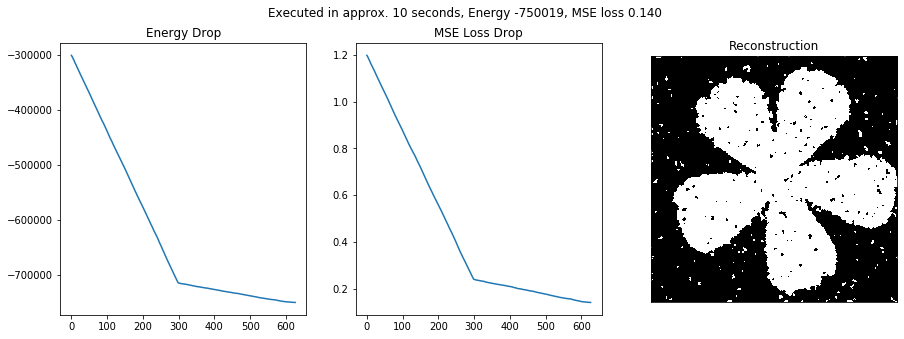

In [125]:
# line-by-line, 1 minute
img_mcmc, e_mcmc, loss_mcmc = evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                         epochs=5*epochs, mode='line', t_max=10)

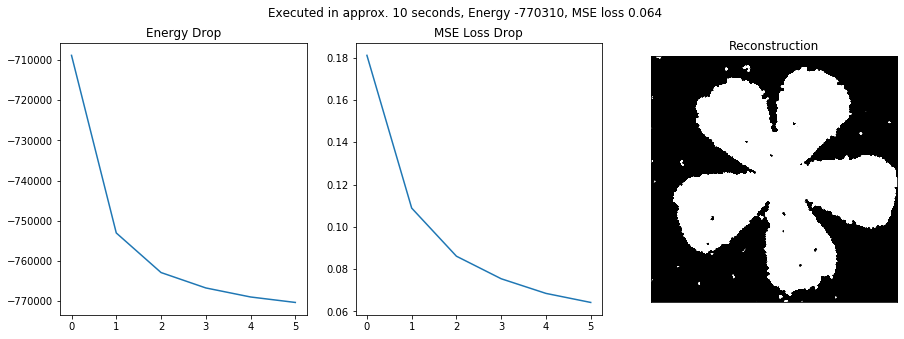

In [127]:
# line-by-line, 1 minute
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=10)

For 5 minutes performances are comparable:

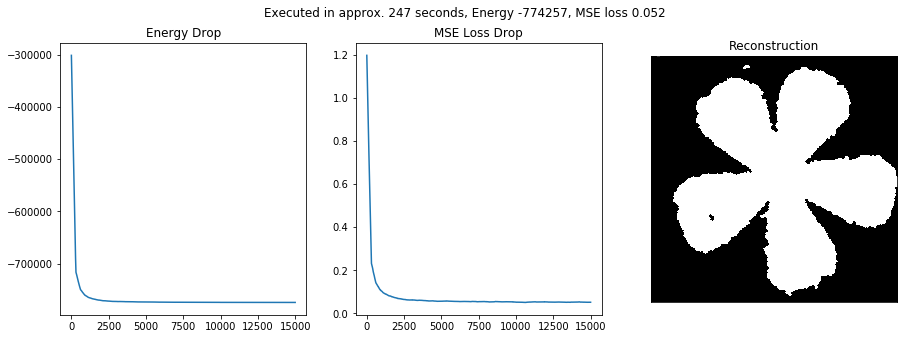

In [169]:
# line-by-line, 5 minutes
img_mcmc, e_mcmc, loss_mcmc = evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                         epochs=5*epochs, mode='line', t_max=300)

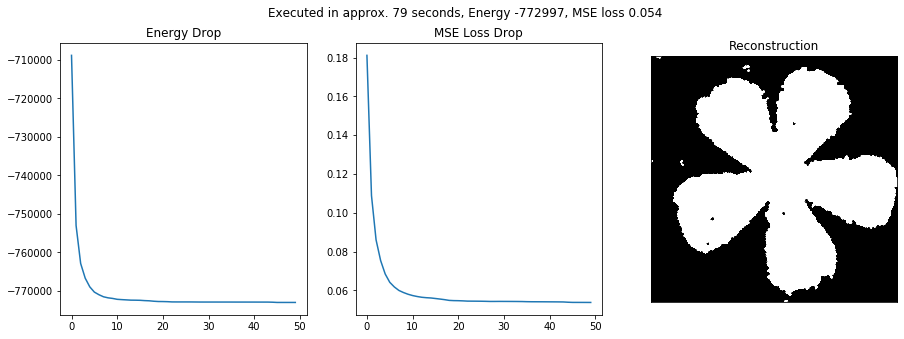

In [170]:
# line-by-line, 5 minutes
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=300)

So we can __conclude__, that 

+  +the mean-field in this setting seems to converge better

- -it can converge to local minimum, though MCMC converges to global under Markov chain central limit theorem conditions (and there choice of pixels should be random)

**Another picture**

Let's check now for another, more complex image - QR-code (random from the internet)

(370, 403)


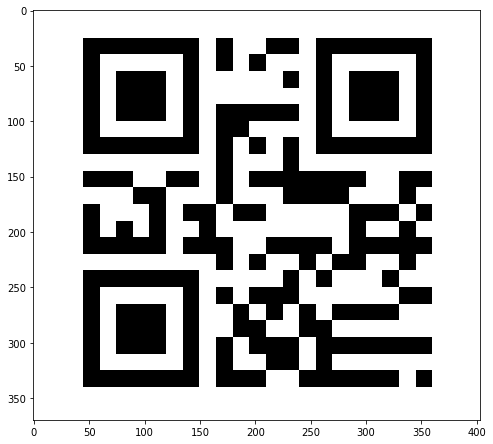

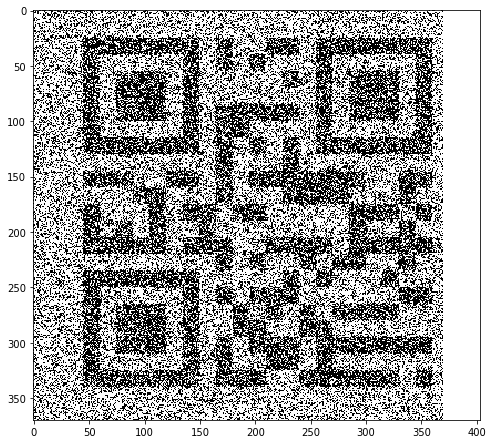

In [159]:
IMG_ORIGINAL_1 = mpimg.imread("qrcode.png")[:,:,0]
IMG_ORIGINAL_1[IMG_ORIGINAL_1 > 0.5] = 1
IMG_ORIGINAL_1[IMG_ORIGINAL_1 <= 0.5] = -1
IMG_HEIGHT_1 = IMG_ORIGINAL_1.shape[0]
IMG_WIDTH_1 = IMG_ORIGINAL_1.shape[1]
print(IMG_ORIGINAL_1.shape)
IMG_ORIGINAL_1.shape
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL_1, cmap='gray')
plt.show()

IMG_NOISY_OBSERVATION_1 = IMG_ORIGINAL_1.copy()
num_flips = int(0.3 * IMG_HEIGHT_1 * IMG_WIDTH_1)

perm = np.random.permutation(IMG_ORIGINAL_1.size)[0:int(0.3 * IMG_ORIGINAL_1.size)]
for k in perm:
    i = int(k/IMG_WIDTH_1)
    j = k%IMG_HEIGHT_1
    IMG_NOISY_OBSERVATION_1[i,j] = -IMG_NOISY_OBSERVATION_1[i,j]
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION_1, cmap='gray')
plt.show()

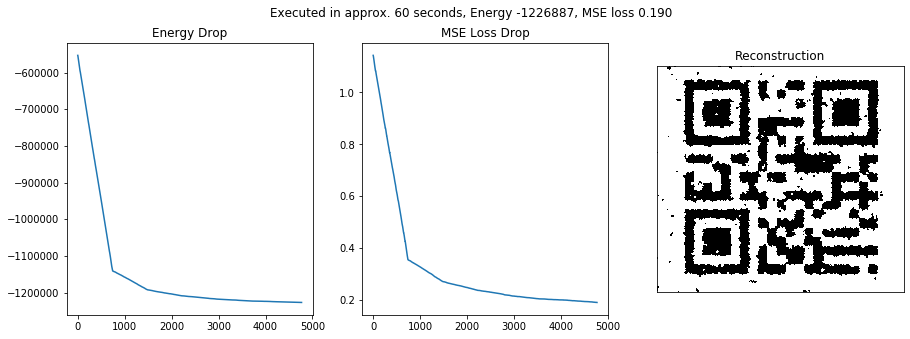

In [162]:
# MCMC, line-by-line, 1 minute
img_mcmc, e_mcmc, loss_mcmc = evaluate(metropolis, IMG_NOISY_OBSERVATION_1, IMG_ORIGINAL_1,
                                         epochs=5*epochs, mode='line', t_max=60)

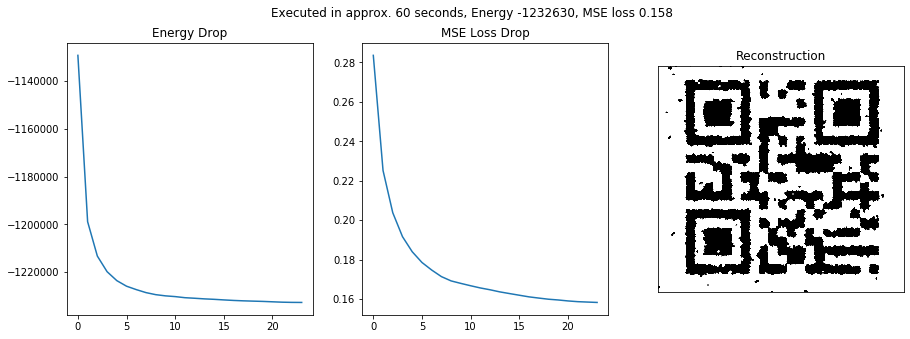

In [163]:
# MF,  line-by-line, 1 minute
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION_1, IMG_ORIGINAL_1,
                                 epochs = 5*epochs, mode='line', t_max=60)

Here MF is a little better

5 minutes

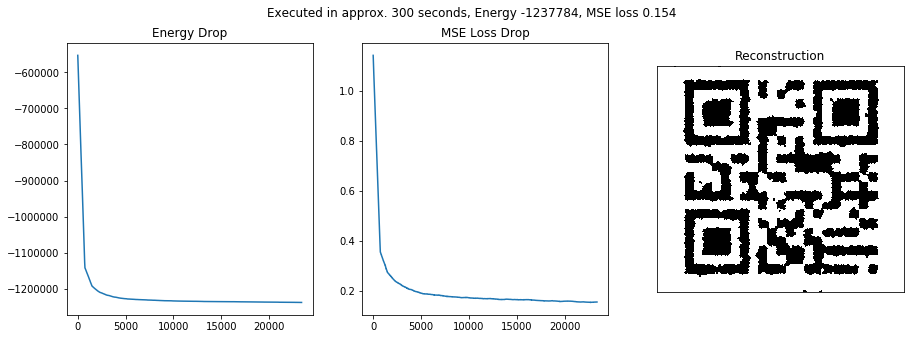

In [165]:
# MCMC, line-by-line, 5 minutes
img_mcmc, e_mcmc, loss_mcmc = evaluate(metropolis, IMG_NOISY_OBSERVATION_1, IMG_ORIGINAL_1,
                                         epochs=5*epochs, mode='line', t_max=300)

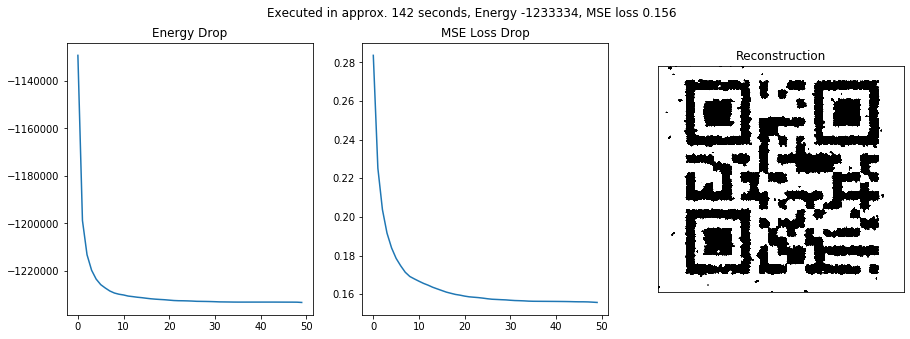

In [166]:
# MF,  line-by-line, 5 minutes
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION_1, IMG_ORIGINAL_1,
                                 epochs = 5*epochs, mode='line', t_max=300)

Using 5 minutes MF and MCMC show almost the same MSE

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
Comment on the convergence of the method by answering these two questions.
    <br>1) How can we tell if the mean field convereged? 
    <br>2) Do we always reach the global optimum?
</p>

1) We can track energy and see if it starts to change slowly, then we converged (could be well seen at the plots $\texttt{evaluate}$ makes)

2) From the Theorem 1 (lecture 07.04.20, slide 12) we can say only that there is a convergence to the local minimum (maybe under other conditions it could converge to global minimum, but during lectures it hasn't mentioned and is probably not true in general. E.g. with various parameters in the next section we obtain different results, which are local minima)

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
How do the parameters of the Ising model, and the temperature affect the performance of the mean field?
Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. 
    <br>1) Can you explain the behaviour? 
    <br>2) Do you see a difference in the reconstraction at different temperature?
</p>

We already varied some parameters in 4.0 section (choice schedule, epochs and running time)

Now we can vary H, Beta and Eta as Ising model parameters. Other are default (from the beginning of the notebook) when we change one. They all are nonnegative (otherwise will be non-physical meaningless effect) 

Plus T.

We don't have other parameters (except used method, but it's MF).

It's not clear what meant by 'parameters of mean field algorithm' which are not Ising model parameters. Is it's time, epochs, then we made it in 4.0 section.

default values

T = 1.0

H = 0.0

Beta = 1.0

Eta = 2.1

**Varying T**

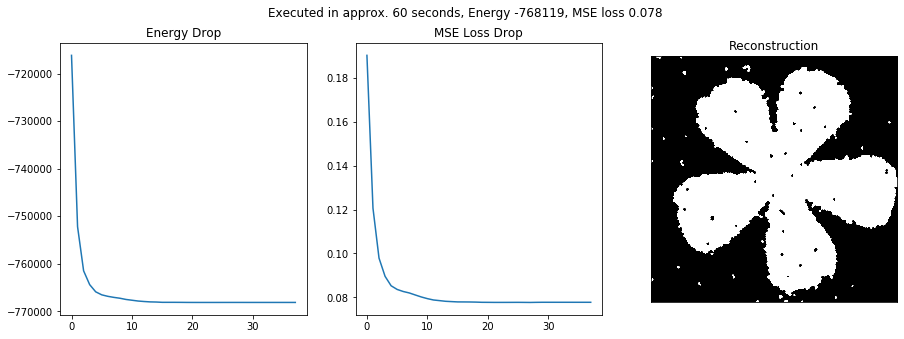

In [173]:
# T=0.5
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=0.5)

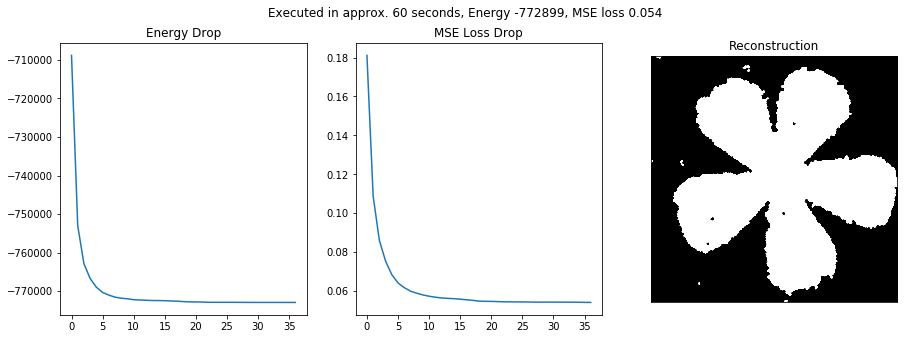

In [175]:
# T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1)

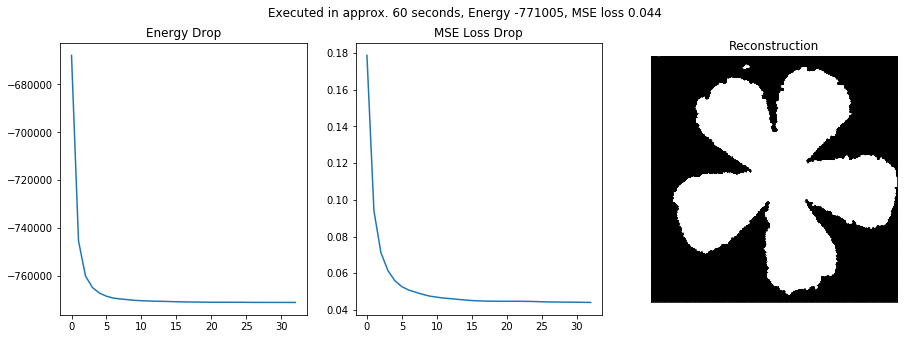

In [181]:
# T=2
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=2)

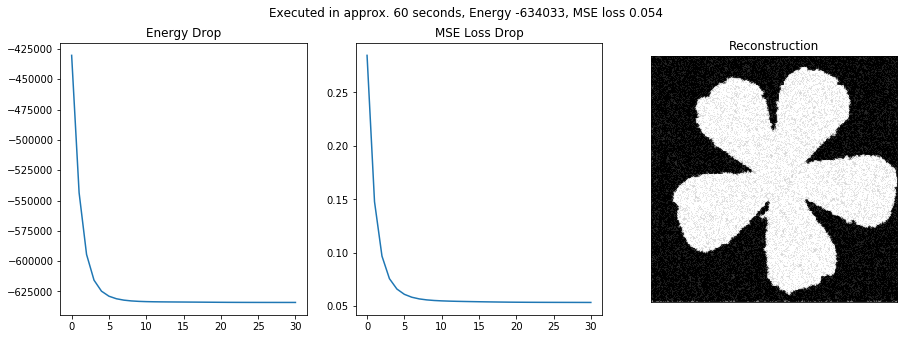

In [182]:
# T=5
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=5)

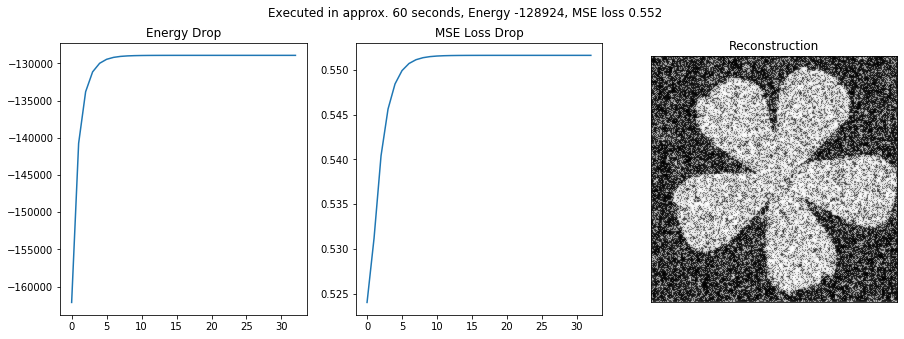

In [179]:
# T=10
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=10)

We see that increasing temperature from 0.5 to 2 can make it better, 
but then at too high temperature (from 5 here) the noisy component starts to break the structure (as neighbors don't mean much then)

**What if we make $H\ne 0$?**

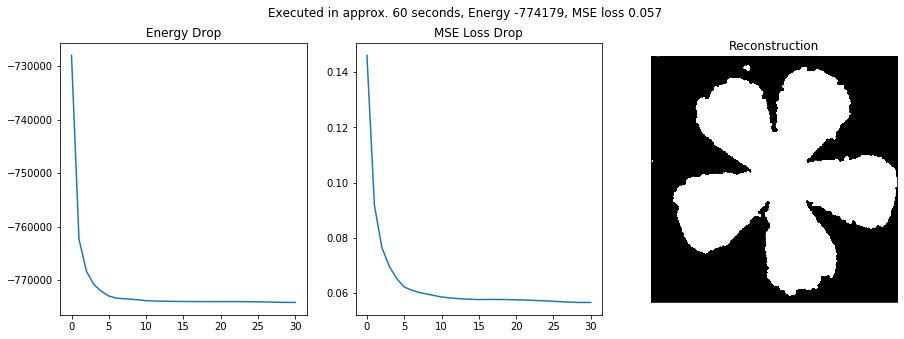

In [200]:
# H=0.2 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 H=0.2)

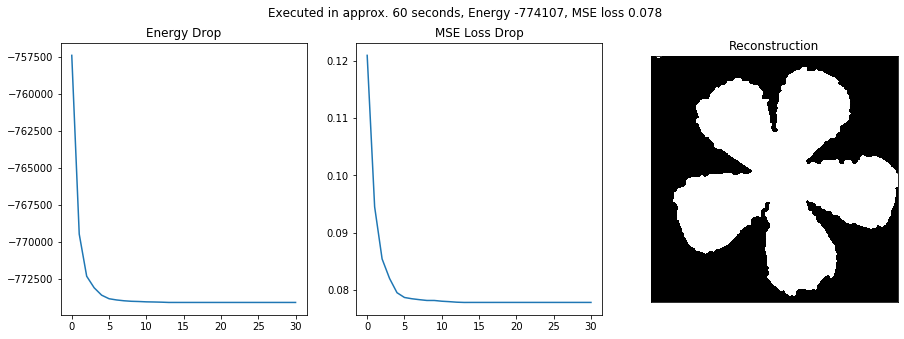

In [201]:
# H=1 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 H=1)

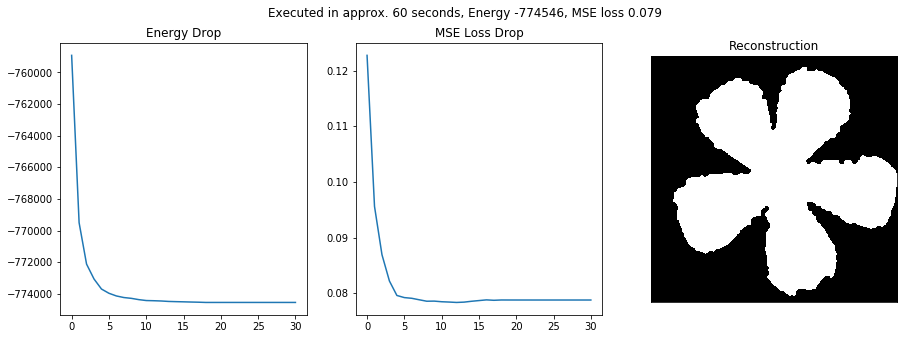

In [202]:
# H=5 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 H=5)

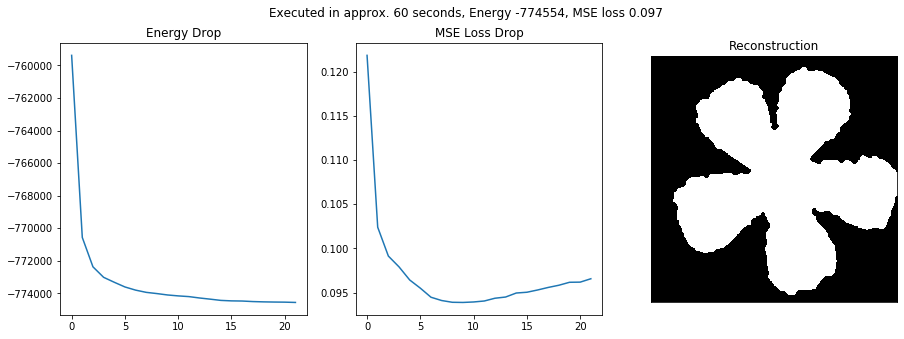

In [203]:
# H=50 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 H=50)

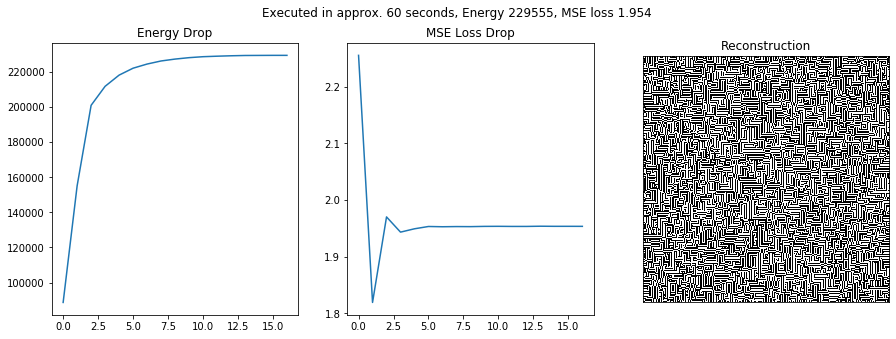

In [214]:
# H=-50 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 H=-50)

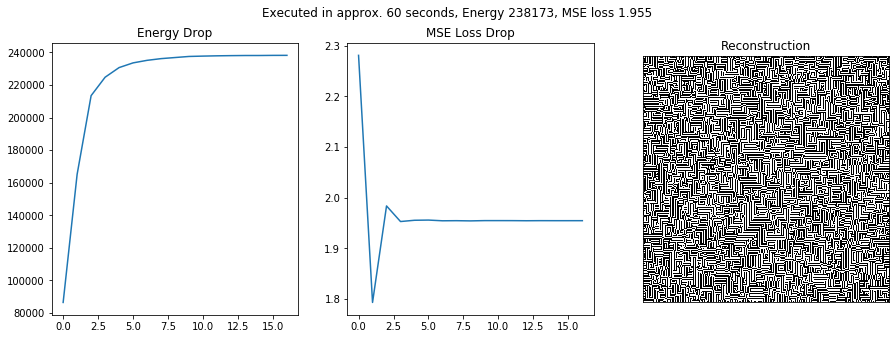

In [218]:
# H=-150 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 H=-150)

We see that change of H make one or another class to be more preferable (so large $H>0$ makes white small clusters to disapper and erodes the central white cluster, $H<0$ does the opposite). It's in agreement with the role of $H$ as the external field.

**Changing $B$**

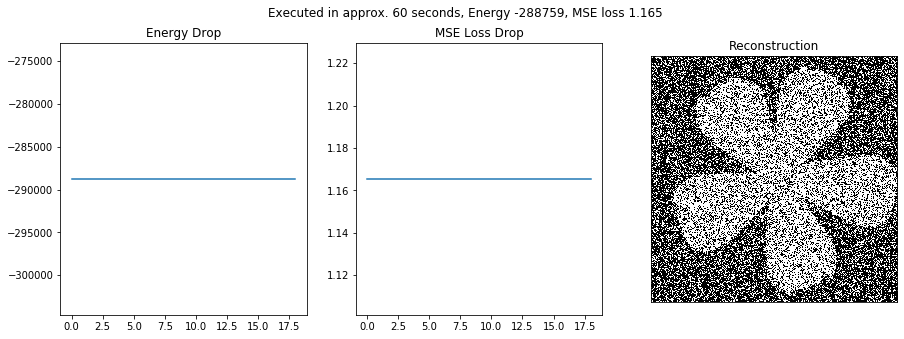

In [208]:
# Beta=0 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Beta=0)

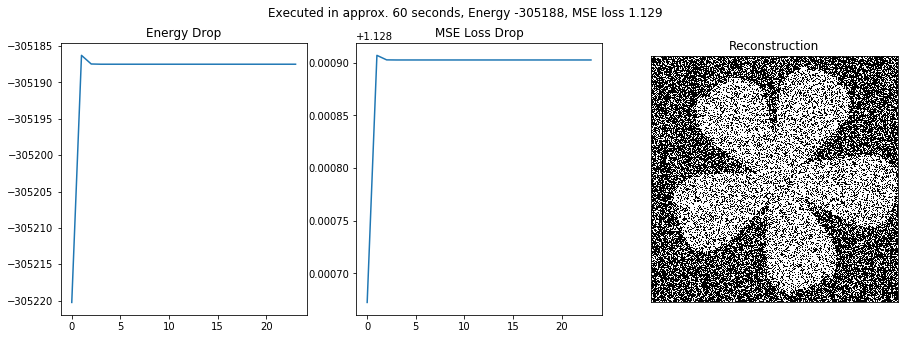

In [204]:
# Beta=0.1 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Beta=0.1)

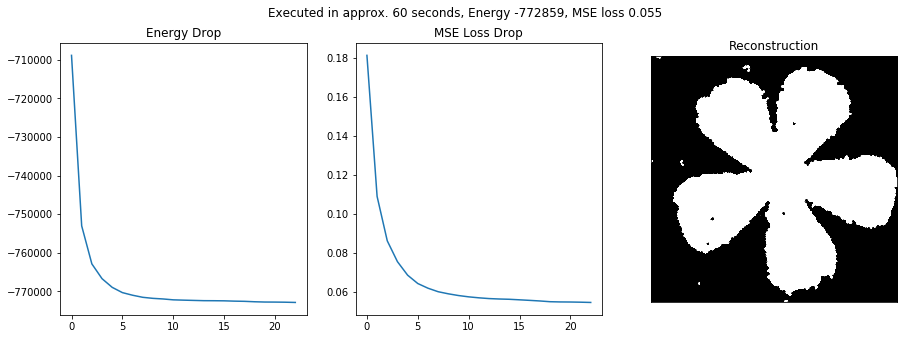

In [205]:
# Beta=1 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Beta=1)

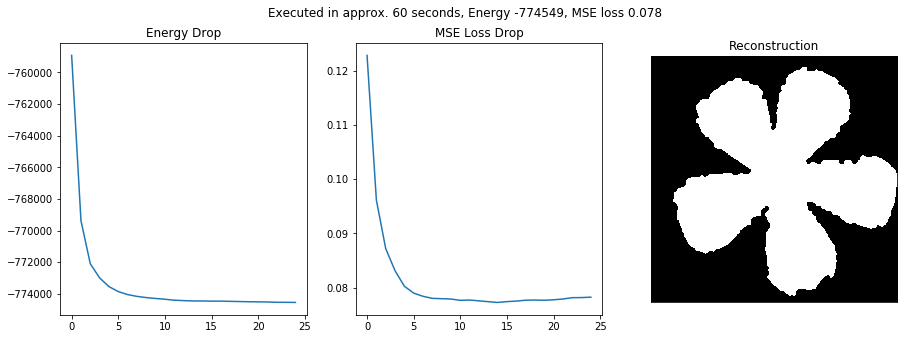

In [206]:
# Beta=5 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Beta=5)

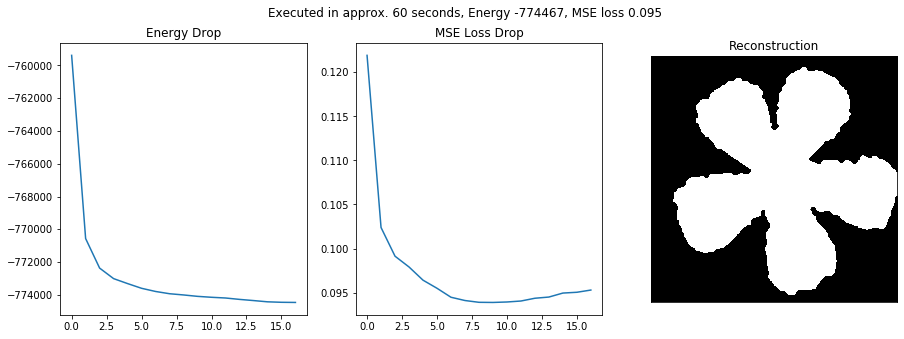

In [216]:
# Beta=50 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Beta=50)

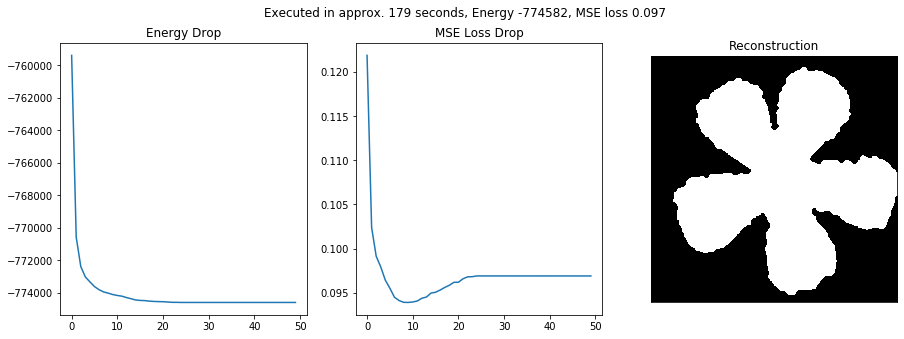

In [215]:
# Beta=50 T=1. More time to see what happens
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=300, T=1,
                                 Beta=50)

We may conclude, that $B<1$ makes denoising unstable, and large $B$ delete small clusters, but erodes the central one (plus at the last MSE plot we can see, that it starts to diverge)

**Changing $\eta$**

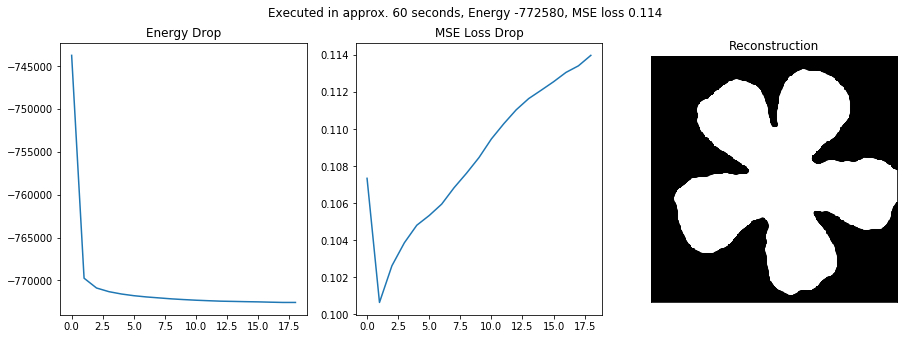

In [209]:
# Eta=0 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Eta=0)

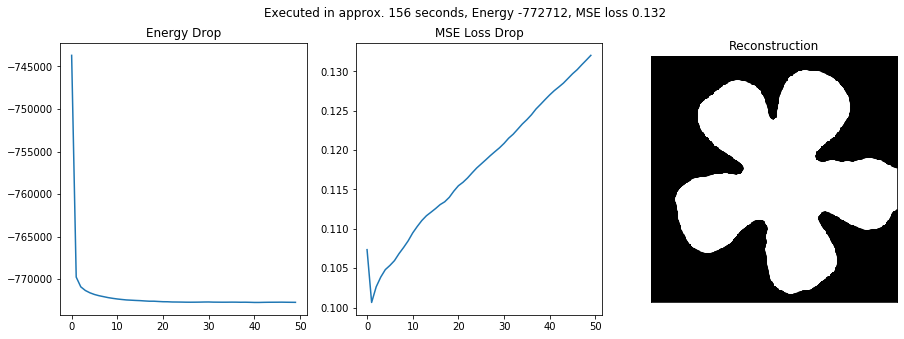

In [217]:
# Eta=0 T=1. More time
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=300, T=1,
                                 Eta=0)

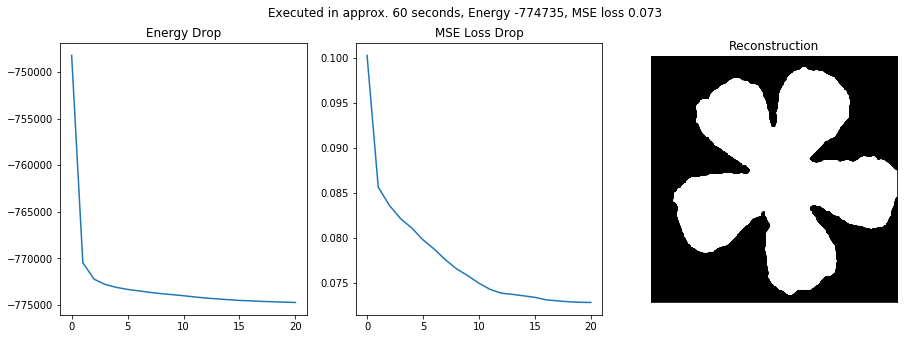

In [210]:
# Eta=0.5 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Eta=0.5)

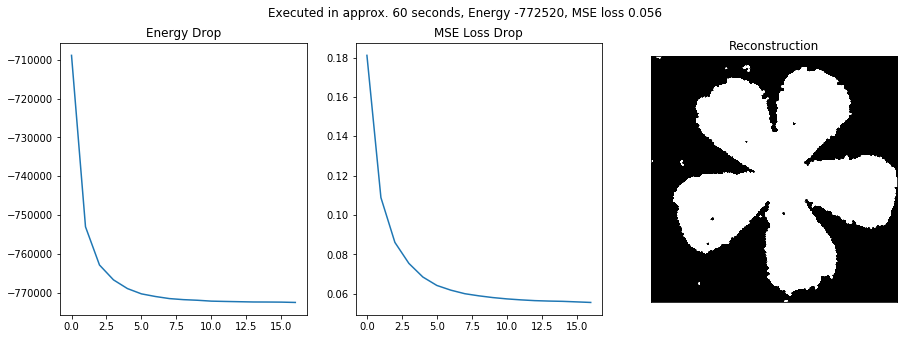

In [211]:
# Eta=2.1 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Eta=2.1)

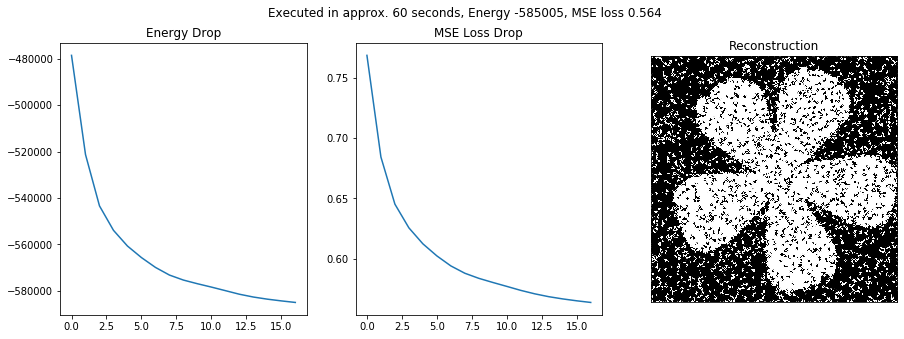

In [212]:
# Eta=5 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Eta=5)

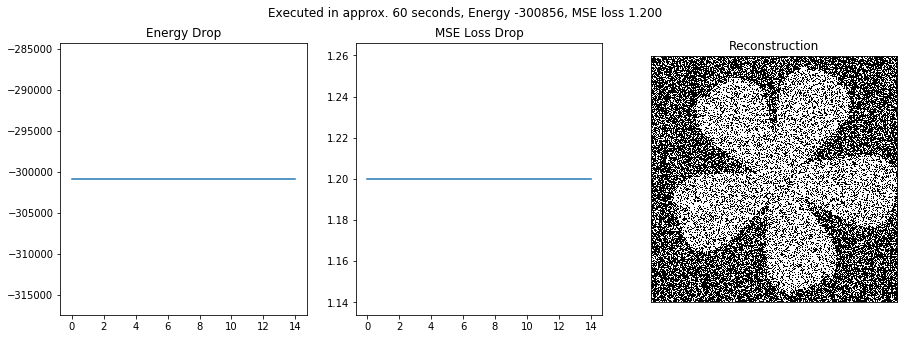

In [213]:
# Eta=50 T=1
img_mf, e_mf, loss_mf = evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL,
                                 epochs = 5*epochs, mode='line', t_max=60, T=1,
                                 Eta=50)

Small $\eta$ makes borders more smooth, though MSE increases, because original image has  cavities on the border.

Large $\eta$ increases dependancy from the noisy image (as $\eta$ controls it) and leads to the result identical to noisy image.

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    For this and for all the following tasks, you have to use a different dataset: the <b>Wine data set</b> (see [4]). This data set contains three classes, see more detailed description online. 
    <br><br>
    Implement both (1) plain-vanilla k-means and (2) smooth k-means in mean field [1], and compare them on the Wine data set.
</p>

In [80]:
# Extract data from file
df = pd.read_csv('wine.data', header=None)
# true classes
labels_true = df[0].tolist()
# chemical data
df = df.drop(0, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [81]:
X = df.values
n, d = np.shape(X)
print(np.shape(X))

(178, 13)


In [82]:
# useful characteristics
maxs = np.max(X, axis=0)
mins = np.min(X, axis=0)
# Get scale information
stds = np.std(X, axis=0)
means = np.mean(X, axis=0)

In [83]:
# Normalize the data (transorm to 0-1)
X = X - means
X = X / stds

In [84]:
k = 3

It's known from the lectures that vanilla k-means corresponds to the cost
$$R(c)=\sum_{i=1}^{n}||x_i - y_{c(i)}||^2,$$
where $x_i\in \mathbb{R}^m$ is data instance in Euclidean space ($i\in\{1,\ldots,n\}$), $c(i)$ is its correspondent cluster at the moment ($c_i\in\{1,\ldots,k\}$, $y_i\in \mathbb{R}^m$ is the coordinates of cluster center at the moment.

For smooth k-means in mean field we have (Lecture 07.04.20, slide 13) the cost
$$R(c)=\sum_{i=1}^n ||x_i - y_{c(i)}||^2 + \frac{\lambda}{2}\sum_{i=1}^n\sum_{j\in\mathcal{N}(i)} \mathbb{1}_{\{c(i)\ne c(j)\}},$$
where $\mathcal{N}(i)$ is somehow determined neighborhood of the point $x_i$.

We can see, that with $\lambda=0$ it will be vanilla k-means.

Recall general EM-like mean field update algorithm (Theorem 1 from Lecture 07.04.20, slide 13) for point index $u$ and cluster $\alpha$ and using update of $h_{u, \alpha}$ for smooth k-means (slide 13 from this lecture):
$$
q_u^{\text{new}}(\alpha) = \frac{e^{-\beta h_{u,\alpha}}}{\sum_{\nu=1}^k e^{-\beta h_{u,\nu}}}$$
and
$$h_{u,\alpha}=||x_u-y_\alpha||^2+\lambda\sum_{j\in\mathcal{N}(u)}\sum_{\nu=1, \nu\ne\alpha}^k q_{j, \nu} + \text{const}.$$

Constant doesn't depend on $u$ and doesn't influence assignment of any object $u$ to any cluster $\alpha$.

Centroids we update using standart centroid equation
$$y_{\nu}=\sum_{i=1}^{n} M_{i \nu} x_{i} / \sum_{i=1}^{n} M_{i \nu}, $$
where $M_{i \nu} = \mathbb{1}_{c(i)==\nu}$ (we can also update with soft assignments ($q$ instead of M in the $y$ update formula)

The question is - __how to define neighborhood__ in data objects space?

In [85]:
# coordinates weighted according to deviation
X_weighted = X
# all distances between x_i
dist = distance_matrix(X_weighted, X_weighted)

Plot their histogram and choose reasonable threshold

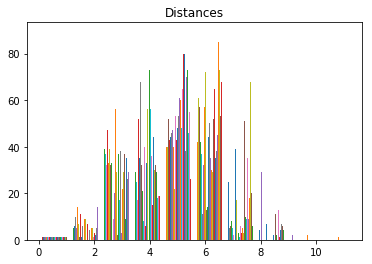

In [86]:
plt.hist(dist)
plt.title('Distances')
plt.show()

Blow-up

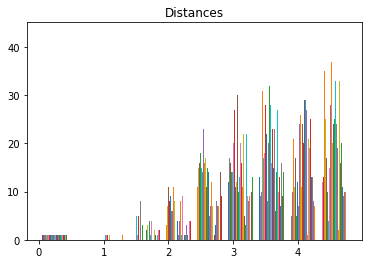

In [87]:
plt.hist(dist, range=[0,4.8])
plt.title('Distances')
plt.show()

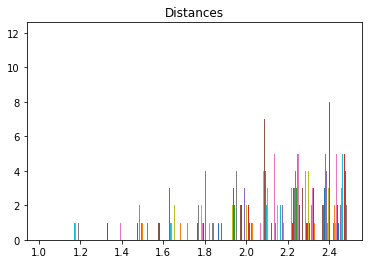

In [88]:
plt.hist(dist, range=[1,2.5])
plt.title('Distances')
plt.show()

Let's take for example threshold 4.5, it's approx. median distance + resulting histogram of neighbors has maximum at approx. 65 (which is 1/k of number of objects) + all objects have at least one neighbor

(possible development: if node has too small number of neighbors, add to them the closest nodes)

[[False  True  True ... False False False]
 [ True False  True ... False False False]
 [ True  True False ... False False False]
 ...
 [False False False ... False  True  True]
 [False False False ...  True False  True]
 [False False False ...  True  True False]]
Number of neighbors
[ 59  82  73  53  97  59  63  62  67  79  61  80  79  46  43  62  59  67
  51  72  66  98  90 108  99  31  84 109  80  89  65  62 112  53 109 104
  92 121 109  47  79 109  66 119  97  65  65  79  81  62  54  69  61  62
  82  73  66  73  63   8  38  78  82  84  67 117  49  71  58   2  92  51
 101   7  82  71  61  94  17  84  62 109  72  79  78  98  86  59  94  68
  84  90  81  87  75   2  20  81  84  48  71  82 115  78  88  66  93  96
  78  75   8  95  53  75  82  31  71  97  78  82  83   1  44  24  28  87
  86  37  81  86  51  76  64  61  70  63  54  44  64  85  83  89  70  70
  52  73  36  54  61  51  36  38  39  41  61  45  53  52   8  24  64  76
  75  77  54  55  45  56  55  39  77  49  53  46  64  46  5

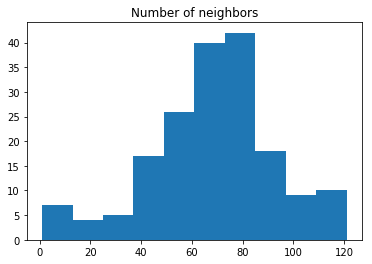

In [89]:
thresh = 4.5
neigh = dist.copy()
neigh[dist > thresh] = 0
# Matrix of neighbor relation
neigh = neigh > 1e-8
print(neigh)
sum_neigh = np.sum(neigh, axis=0)
print('Number of neighbors')
print(sum_neigh)
plt.hist(sum_neigh)
plt.title('Number of neighbors')
plt.show()

In [256]:
# lambda = 0 => vanilla k-means
def k_means(X, lambda_=0.0, k=3, T=1.0, verbose=True, iter_end=-1):
    T = T
    lambda_ = lambda_
    eps = 1e-12

    # choose random initial centers
    np.random.seed(13)
    # y = np.random.rand(k, d)
    y = np.empty((k,d))
    inds = np.random.randint(1, n, k)
    for i in range(k):
        y[i,:] = X[inds[i],:]
    y = np.random.rand(k,d)
    # define initial assignments as closest centers to x_i
    dist_xy = distance_matrix(X, y)
    dist_mins = np.min(dist_xy, axis=1)
    q = np.zeros((n,k))
    for i in range(n):
        label_i = np.where(dist_xy[i,:]==dist_mins[i])[0][0]
        q[i][int(label_i)] = 1 
    # EM-iterations
    h = np.empty((n,k))
    t = 0
    while True:
        t += 1
        q_old = q.copy()  # for convergence condition
        # update h
        dist_xy = distance_matrix(X, y)
        h = dist_xy * dist_xy
        if not np.isclose(lambda_, 0):  # smooth k-means
            for a in range(k):
                q_without_alpha = q.copy()
                q_without_alpha[:,a] = np.zeros((1,n))
                h[:,a] += lambda_ * neigh @ np.sum(q_without_alpha, axis=1).transpose()
        # update q
        hbeta = 1/T*h
        q = np.exp(-hbeta - np.matlib.repmat(logsumexp(-hbeta, axis=1), # 1xn
                                             k, 1).transpose())
        # update y
        # soft assignment of clusters
        y = q.transpose() @ X / np.matlib.repmat(np.sum(q, axis=0), d, 1).transpose()
        labels = np.argmax(q, axis=1)
        M = np.zeros((n,k))
        for i in range(n):
            M[i, labels[i]] = 1
        # rigid assignment of clusters
        #y = M.transpose() @ X / np.matlib.repmat(np.sum(M, axis=0), d, 1).transpose()
        # convergence condition
        if not np.any(norm(q-q_old, axis=1) > eps):
            break
        if iter_end == t:
            break
    if verbose:
        print("{} iterations".format(t))
    labels = np.argmax(q, axis=1)
    return labels, y

We don't use repeating k-means several times as built-in sklearn function, as we want to estimate work of plain and smooth k-means as it is

In [258]:
%%time
labels_vanilla, y_vanilla = k_means(X, lambda_=0.00)

41 iterations
CPU times: user 30.4 ms, sys: 26 µs, total: 30.4 ms
Wall time: 29.4 ms


In [259]:
%%time
labels_smooth_02, y_smooth_02 = k_means(X, lambda_=0.2)

71 iterations
CPU times: user 109 ms, sys: 3.97 ms, total: 113 ms
Wall time: 58.7 ms


In [260]:
labels_smooth_03, y_smooth_03 = k_means(X, lambda_=0.3)
labels_smooth_04, y_smooth_04 = k_means(X, lambda_=0.4)
labels_smooth_05, y_smooth_05 = k_means(X, lambda_=0.5)

22 iterations
12 iterations
17 iterations


In [261]:
%%time
# Built-in, for reference later
km = KMeans(n_clusters=k).fit(X)

CPU times: user 84.5 ms, sys: 5 µs, total: 84.5 ms
Wall time: 92.1 ms


<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.
</p>

We use 3 different methods: T-SNE, locally linear embedding and PCA

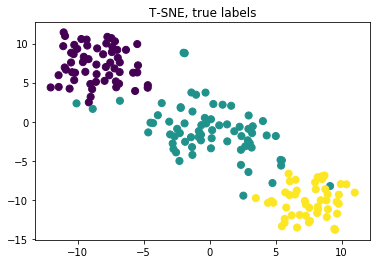

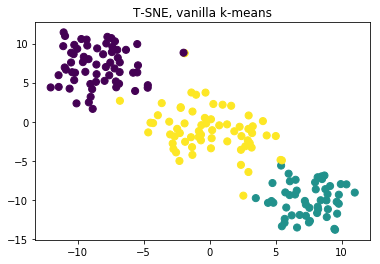

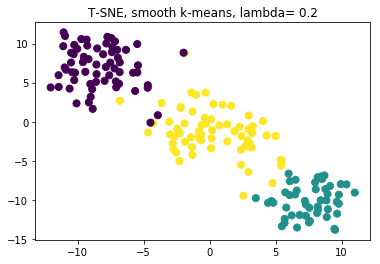

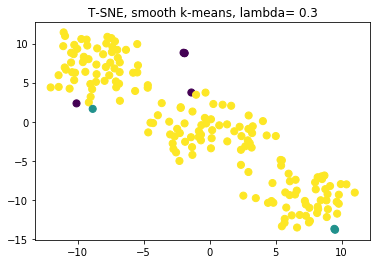

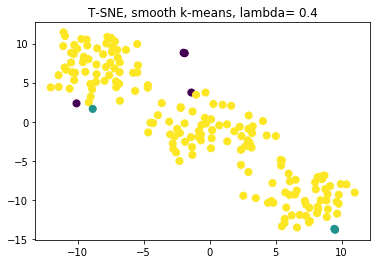

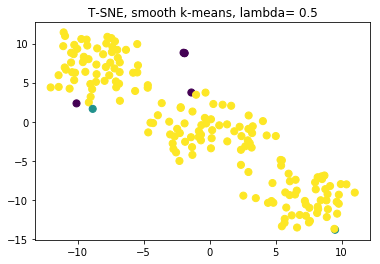

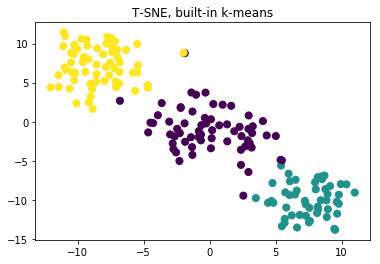

In [263]:
X_tr_tsne = TSNE(n_components=2).fit_transform(X)
fig = plt.figure()
plt.title("T-SNE, true labels")
plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_true, s=50, cmap='viridis')

fig = plt.figure()
plt.title("T-SNE, vanilla k-means")
plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_vanilla, s=50, cmap='viridis')

fig = plt.figure()
plt.title("T-SNE, smooth k-means, lambda= 0.2")
plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_smooth_02, s=50, cmap='viridis')

fig = plt.figure()
plt.title("T-SNE, smooth k-means, lambda= 0.3")
plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_smooth_03, s=50, cmap='viridis')

fig = plt.figure()
plt.title("T-SNE, smooth k-means, lambda= 0.4")
plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_smooth_04, s=50, cmap='viridis')

fig = plt.figure()
plt.title("T-SNE, smooth k-means, lambda= 0.5")
plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_smooth_05, s=50, cmap='viridis')

fig = plt.figure()
plt.title("T-SNE, built-in k-means")
plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=km.labels_, s=50, cmap='viridis')

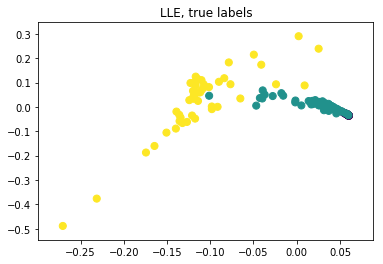

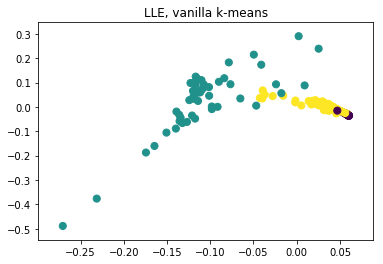

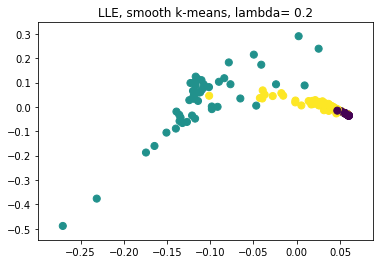

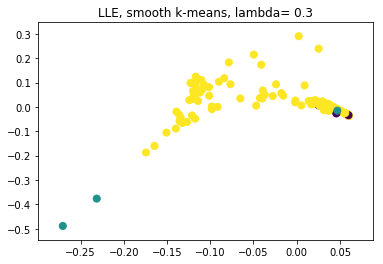

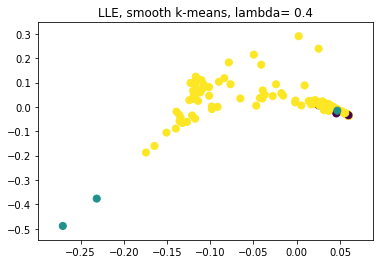

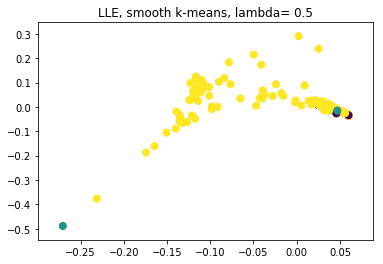

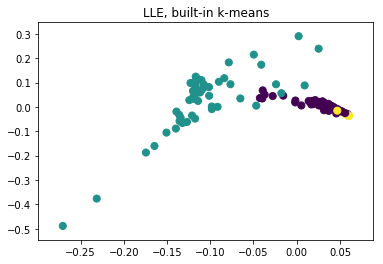

In [102]:
X_tr_lle = LocallyLinearEmbedding(n_neighbors=5, n_components=2).fit_transform(X)
fig = plt.figure()
plt.title("LLE, true labels")
plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=labels_true, s=50, cmap='viridis')

fig = plt.figure()
plt.title("LLE, vanilla k-means")
plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=labels_vanilla, s=50, cmap='viridis')

fig = plt.figure()
plt.title("LLE, smooth k-means, lambda= 0.2")
plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=labels_smooth_02, s=50, cmap='viridis')

fig = plt.figure()
plt.title("LLE, smooth k-means, lambda= 0.3")
plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=labels_smooth_03, s=50, cmap='viridis')

fig = plt.figure()
plt.title("LLE, smooth k-means, lambda= 0.4")
plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=labels_smooth_04, s=50, cmap='viridis')

fig = plt.figure()
plt.title("LLE, smooth k-means, lambda= 0.5")
plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=labels_smooth_05, s=50, cmap='viridis')

fig = plt.figure()
plt.title("LLE, built-in k-means")
plt.scatter(X_tr_lle[:, 0], X_tr_lle[:, 1], c=km.labels_, s=50, cmap='viridis')

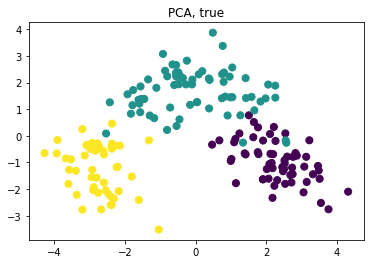

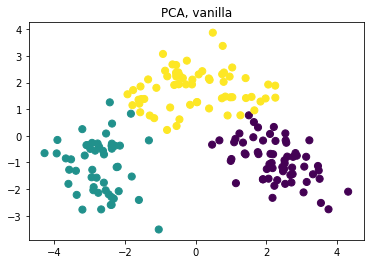

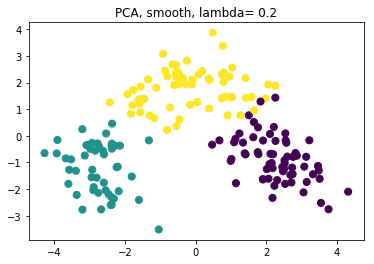

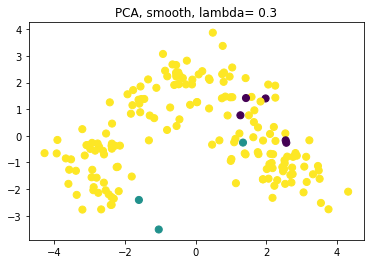

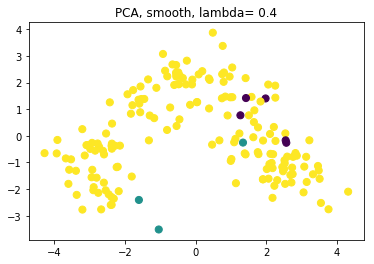

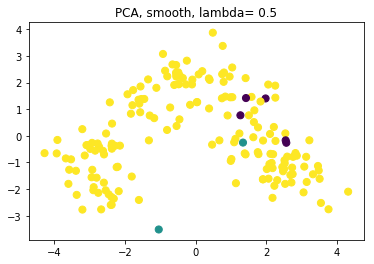

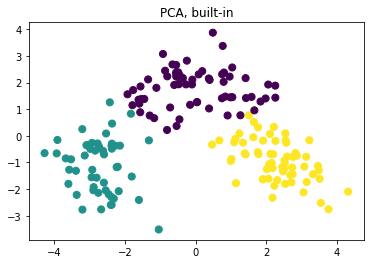

In [264]:
X_tr_pca = PCA(n_components=2).fit_transform(X)
fig = plt.figure()
plt.title("PCA, true")
plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=labels_true, s=50, cmap='viridis')

fig = plt.figure()
plt.title("PCA, vanilla")
plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=labels_vanilla, s=50, cmap='viridis')

fig = plt.figure()
plt.title("PCA, smooth, lambda= 0.2")
plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=labels_smooth_02, s=50, cmap='viridis')

fig = plt.figure()
plt.title("PCA, smooth, lambda= 0.3")
plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=labels_smooth_03, s=50, cmap='viridis')

fig = plt.figure()
plt.title("PCA, smooth, lambda= 0.4")
plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=labels_smooth_04, s=50, cmap='viridis')

fig = plt.figure()
plt.title("PCA, smooth, lambda= 0.5")
plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=labels_smooth_05, s=50, cmap='viridis')

fig = plt.figure()
plt.title("PCA, built-in")
plt.scatter(X_tr_pca[:, 0], X_tr_pca[:, 1], c=km.labels_, s=50, cmap='viridis')

Using T-SNE and PCA clusters are seen the best
As expected, smooth k-means force cluster be more wide (in limit of big $\lambda$ one cluster for almost all objects, see $\lambda=0.5$)

With $\lambda=0$ we have similar result to built-in k-means (we don't repeat)

In [104]:
print("adjusted_rand_score")
print("built-in - vanilla - smooth_0.2\n{:.5f} - {:.5f} - {:.5f}".format(\
    metrics.adjusted_rand_score(km.labels_, labels_true),
    metrics.adjusted_rand_score(labels_vanilla, labels_true),
    metrics.adjusted_rand_score(labels_smooth_02, labels_true)
    ))
print("\nadjusted_mutual_info_score")
print("built-in - vanilla - smooth_0.2\n{:.5f} - {:.5f} - {:.5f}".format(\
    metrics.adjusted_mutual_info_score(km.labels_, labels_true),
    metrics.adjusted_mutual_info_score(labels_vanilla, labels_true),
    metrics.adjusted_mutual_info_score(labels_smooth_02, labels_true)
    ))

adjusted_rand_score
built-in - vanilla - smooth_0.2
0.89749 - 0.89749 - 0.89506

adjusted_mutual_info_score
built-in - vanilla - smooth_0.2
0.87162 - 0.87162 - 0.87889


/home/anton/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


<p style="background-color:#adebad;">
Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.
</p>

We see that with some values of $\lambda$ we have some scores better (adjusted mutual info for $\lambda=0.2$). So it makes sense to use it in some cases.

But smooth k-means also depends on how we determine neighborhood. And if as we do, what is the threshold. For example, with threshold 3 (closer neighbors) we'll have identical labelings in all cases of lambda from 0.2 to 0.5, it won't change labelings of vanilla k-means

<p style="background-color:#adebad;">
Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). 
    <br>1) Does it indicate 3 clusters? 
    <br>2) How does the smooth k-means clustering solution change when varying the temperature of the mean field approximation?
</p>

Using 

[1] https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans

and 

[2] https://github.com/bobhancock/goxmeans/blob/master/doc/BIC_notes.pdf

In our notation ($y$ - centers of clusters, $k$ - their number, $l_i$ - number of elements in cluster $i$, $d$ - number of features, $n$ - number of objects) 

(6) in [2]:

$$\sigma_i = \frac{1}{n - k}\sum_{j: c(j)=i} ||x_j - y_i||^2$$

We use adapted code from the first answer to [1]

In [265]:
def bic_score(labels, X, y):
    k = np.shape(y)[0]
    n, d = X.shape
    # sizes of clusters
    l = np.bincount(labels, minlength=k)
    const_term = 0.5 * k * np.log(n) * (d+1)
    cl_var = 0
    for i in range(k):
        cl_var += (1.0 / (n - k) / d) * \
                np.sum(norm(X[np.where(labels == i)] - y[i,:])**2)
    bic_score = -np.sum([l[i] * np.log(l[i]) -
               l[i] * np.log(n) -
             ((l[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((l[i] - 1) * d / 2) for i in range(k)]) - const_term
    return bic_score

In [266]:
def plot_bic(k_min, k_max, X, lambda_=0.0):
    ks = [i for i in range(k_min, k_max)]
    bics = []
    for k in range(k_min, k_max):
        labels, y = k_means(X, k=k, lambda_=lambda_, verbose=False)
        bics.append(bic_score(labels, X, y))
    plt.plot(ks, bics, '-')
    plt.title("$\lambda$={}".format(lambda_))
    plt.xlabel("k")
    plt.ylabel("BIC")

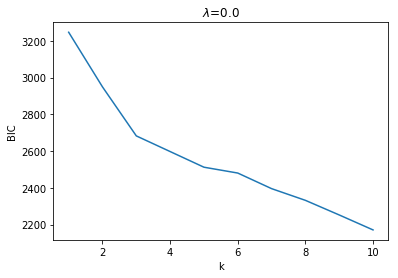

In [267]:
plot_bic(1, 11, X, lambda_=0.0)

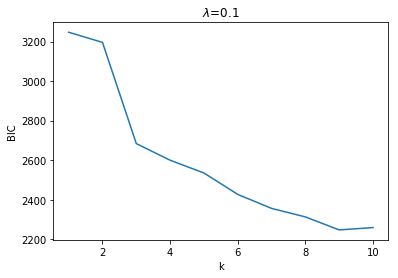

In [268]:
plot_bic(1, 11, X, lambda_=0.1)

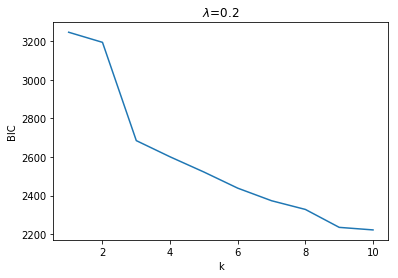

In [269]:
plot_bic(1, 11, X, lambda_=0.2)

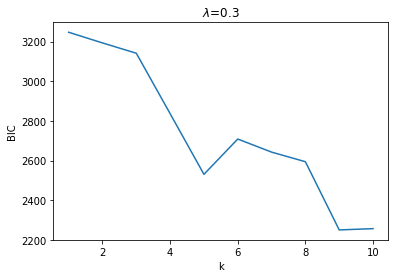

In [270]:
plot_bic(1, 11, X, lambda_=0.3)

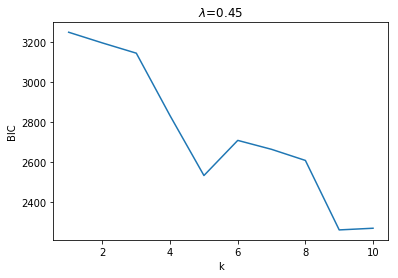

In [271]:
plot_bic(1, 11, X, lambda_=0.45)

We see that BIC stops to drop fast at $k=3$, which indicates that we have 3 clusters. Probably, space is too much dimensional, so we don't see clear minimum

With big $\lambda > 0.2$ it seems that there is minimum at $5$, but the situation is more unstable (as we saw from the plots before, one cluster starts to get all objects), and BIC decreases further fast

**Varying temperature for smooth k-means**

In [215]:
X_tr_tsne = TSNE(n_components=2).fit_transform(X)

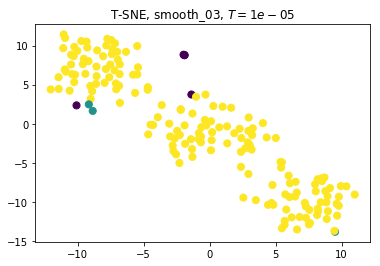

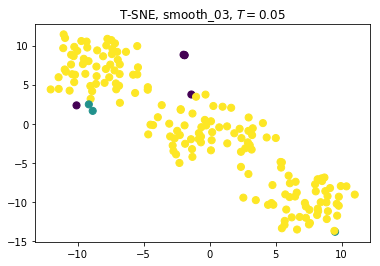

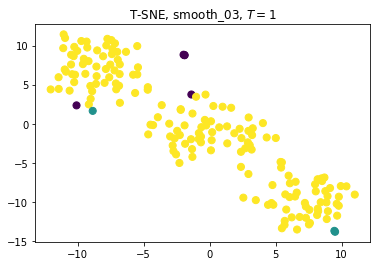

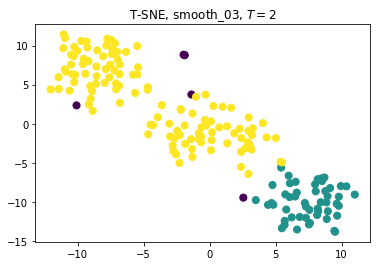

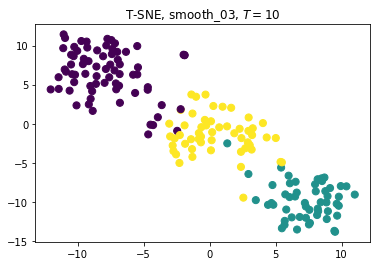

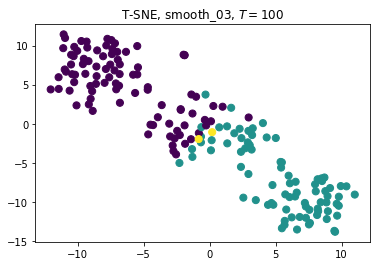

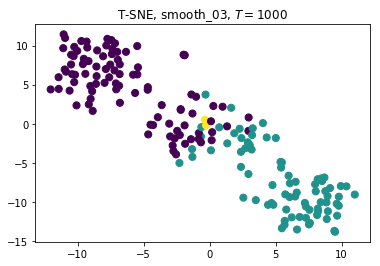

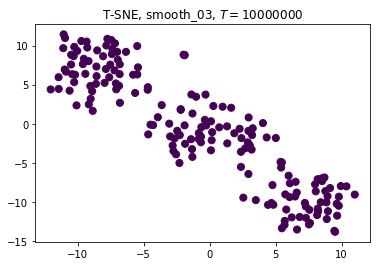

In [272]:
lambda_ = 0.3
for T in [1e-5, 0.05, 1, 2, 10, 100, 1000, 10000000]:
    labels_smooth, y_smooth = k_means(X, lambda_=lambda_, T=T, verbose=False)
    fig = plt.figure()
    plt.title("T-SNE, smooth_03, $T={}$".format(T))
    plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_smooth, s=50, cmap='viridis')

Let's look at clusters "moving" between iterations

1 iterations
2 iterations
3 iterations
1 iterations
2 iterations
3 iterations
1 iterations
2 iterations
3 iterations


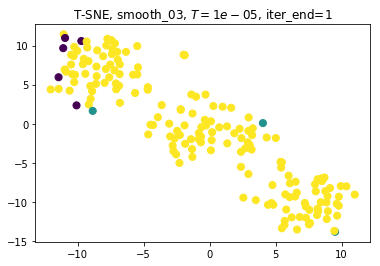

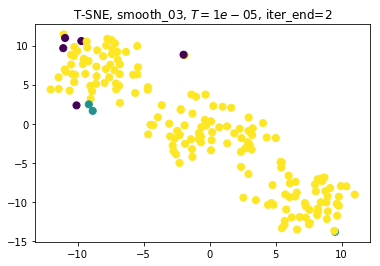

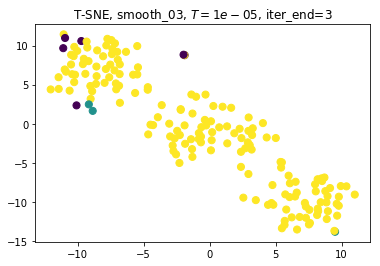

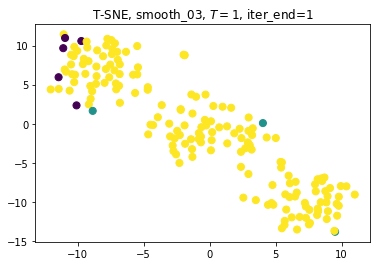

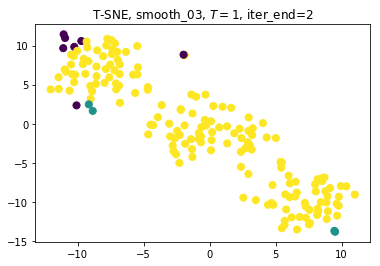

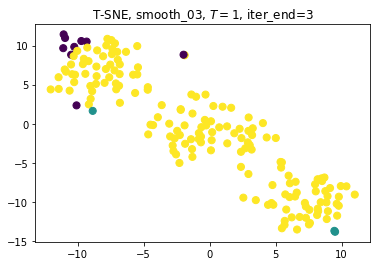

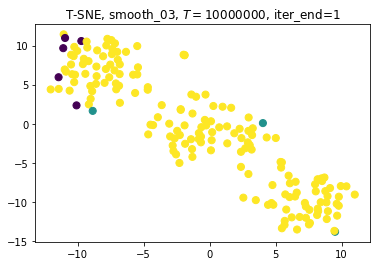

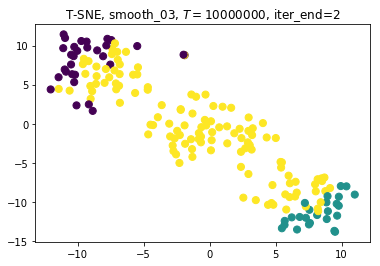

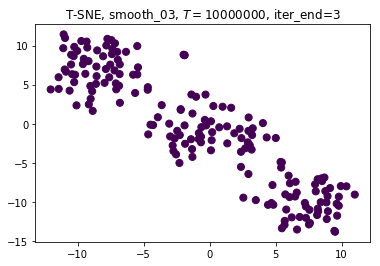

In [275]:
for T in [1e-5, 1, 10000000]:
    for iter_end in [1, 2, 3]:
        labels_smooth, y_smooth = k_means(X, lambda_=lambda_, T=T,
                                          iter_end=iter_end, verbose=True)
        fig = plt.figure()
        plt.title("T-SNE, smooth_03, $T={}$, iter_end={}".format(T, iter_end))
        plt.scatter(X_tr_tsne[:, 0], X_tr_tsne[:, 1], c=labels_smooth, s=50, cmap='viridis')

With big temperature clusters are more "aggressive"(at $T=10^{7}$ purple occupies all others in 3 steps)

Recall

$$
q_u^{\text{new}}(\alpha) = \frac{e^{-\beta h_{u,\alpha}}}{\sum_{\nu=1}^k e^{-\beta h_{u,\nu}}}$$
and
$$h_{u,\alpha}=||x_u-y_\alpha||^2+\lambda\sum_{j\in\mathcal{N}(u)}\sum_{\nu=1, \nu\ne\alpha}^k q_{j, \nu} + \text{const}.$$

The more the temperature is, the more distribution of $q$ (in softmax form) goes from  something concetrated (like delta-function) to uniform ($q_u(\alpha)\approx 1/k$)  w.r.t. neighbors of the same cluster.

That means, with big $T$ looking at the formula for $h$ we can see, that sums of q are constant if neighbor has different class. It is more beneficial for all to have one class (this constant will be 0 then), classes tend to merge.

With small temperature $h$ the closest neighbor wins, so they also have all the same class sequentially.

For normal middle temperature it's more like plain k-means, as neighbor effect isn't extreme.
plain-vanilla k-means, 

(with super-high temperature we also, probably, could have computational errors due to super small numbers)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.

BIC wasn't in lectures in needed  for this